In [3]:
import pandas as pd
import os
from collections import Counter
import seaborn as sns
import glob
from tqdm.notebook import tqdm
from gensim.models import word2vec
import collections
from scipy.stats import entropy
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import phate
import pacmap
import numpy as np
from scipy.spatial import ConvexHull
from numpy.linalg import norm
from numpy import dot
import matplotlib.pyplot as plt
import matplotlib as mpl
import reverse_geocode 
import pycountry_convert as pc
import scipy
#os.chdir("/maps/hdir/mgd405")

In [7]:
#number of authors 
sequences=pd.read_pickle('../../../data/author_sequence.pickle')
len(sequences)

29107

In [3]:
# some functions
def similarity(w,v):
    if sum(w-v)==0:
        sim=1
    else:
        sim=dot(w, v)/(norm(w)*norm(v))
    return sim
def distance_norm(x):
    a=0
    if len(x)>1:
        for i in range(1,len(x)):
            a+=1-similarity(x[i,:],x[i-1,:])
    else:
        a=0
    return a

def distance_std(x):
    if len(x)>1:
        ls=[]
        for i in range(1,len(x)):
            ls.append(1-similarity(x[i,:],x[i-1,:]))
        a=np.std(ls)
    else:
        a=0
    return a

def ConvexArea(x):
    try:
        hull=ConvexHull(x)
        a=hull.volume
    except:
        a=0
    return a

def Averagetocentroid(x):
    if len(x)>1:
        ls=[]
        centriod=np.mean(x, axis=0)
        for i in range(len(x)):
            ls.append(1-similarity(x[i,:],centriod))
        a=np.std(ls)
    else:
        a=0
    return a

def JumpSize(x): 
    if len(x)>1:
        ls=[]
        for i in range(len(x)):
            ls.append(1-similarity(x[i,:],x[i-1,:]))
        return ls
    
def Gyration(x):
    if len(x)>1:
        ls=[]
        centriod=np.mean(x, axis=0)
        for i in range(len(x)):
            ls.append(np.dot(x[i,:]-centriod, x[i,:]-centriod))
        a=np.sqrt(sum(ls)/len(ls))
    else:
        a=0
    return a

def middle(x):
    return np.mean(x, axis=0)

def explode(df, columns):
    df_1=df.explode(columns[0]).reset_index(drop=True)
    for i in columns[1:]:
        df_1[i]=df.explode(i).reset_index(drop=True)[i]
    return df_1

def to_list(df, columns):
    for i in columns:
        df[i]=df[i].apply(lambda x: x.split('; '))
    return df

def estimate_shannon_entropy(dna_sequence):
    bases = collections.Counter([tmp_base for tmp_base in dna_sequence])
    # define distribution
    dist = [x/sum(bases.values()) for x in bases.values()]
 
    # use scipy to calculate entropy
    entropy_value = entropy(dist, base=2)
 
    return entropy_value

def trips(sequence):
    ls=[]
    for i in range(1,len(sequence.split('; '))):
        ls.append(sequence.split('; ')[i-1]+"-"+ sequence.split('; ')[i])    
    return ls

**train periodical embeddings**

In [9]:
#os.chdir("../01.model_training")
from p2v import train_p2v

common_texts=[i for i in sequences.VenueId.apply(lambda x:x.split('; '))]
train_p2v(common_texts, 100, 10, 2)

In [2]:
model=word2vec.Word2Vec.load('../01.model_training/j2v_100d_2c_10m')

**some pre-processing** 

In [5]:
# some processing 
sequences=to_list(sequences,['Year','VenueId','PaperId','PaperTitle','CitationCount'])
sequences['OriginalVenue']=sequences.OriginalVenue.apply(lambda x: x.split('$;$ '))
sequences['Age']=sequences.Year.apply(lambda x: 2022- min([eval(i) for i in x]))

In [6]:
# citation indicators
sequences['AverageCitation']=sequences.CitationCount.apply(lambda a: sum([eval(i) for i in a])/len(a))
sequences['MedianCitation']=sequences.CitationCount.apply(lambda a:np.median([eval(i) for i in a]))
sequences['Percentile75Citation']=sequences.CitationCount.apply(lambda a:np.quantile([eval(i) for i in a], q=[0.75])[0])

In [7]:
journal_sequence=explode(sequences,['Year','PaperId','VenueId','PaperTitle','OriginalVenue','CitationCount'])

In [8]:
# Get the trained periodical embeddings 
we_dict = dict({})
for idx, key in enumerate(journal_sequence.VenueId.to_list()):
    try:
        we_dict[key] = model.wv[key]
    except:
        pass
X=np.array([j for i,j in we_dict.items() ])
tokens=np.array([i for i,j in we_dict.items()])
tokens_idx={k: v for v, k in enumerate(tokens)}

X.shape # number of periodicals in the embedding space 

(11909, 100)

<hr>

**periodical embedding space**

Note that the author and journal information were mined from the [MAG dataset](https://learn.microsoft.com/en-us/academic-services/graph/reference-data-schema)

In [9]:
# tsne
def tsne_plot(X):
    X=np.array(X)
    pca = PCA(n_components=50)
    X_pca=pca.fit_transform(X)
    proj = TSNE().fit_transform(X_pca)
    return proj
proj=tsne_plot(X)

# UMAP 
proj_1 = umap.UMAP(n_components=2, metric='cosine').fit_transform(X)

# PHATE 
phate_operator = phate.PHATE(n_components=2, knn_dist='cosine', mds_dist ='cosine')
proj_2 = phate_operator.fit_transform(X)



/home/unicph.domain/mgd405/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/unicph.domain/mgd405/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Calculating PHATE...
  Running PHATE on 11909 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...


/home/unicph.domain/mgd405/anaconda3/lib/python3.7/site-packages/graphtools/graphs.py:238: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  UserWarning,


    Calculated KNN search in 2.13 seconds.
    Calculating affinities...
    Calculated affinities in 0.17 seconds.
  Calculated graph and diffusion operator in 2.31 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.16 seconds.
    Calculating KMeans...
    Calculated KMeans in 14.59 seconds.
  Calculated landmark operator in 18.07 seconds.
  Calculating optimal t...
    Automatically selected t = 34
  Calculated optimal t in 2.43 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.29 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.61 seconds.
Calculated PHATE in 29.74 seconds.


In [403]:
# pacmap 
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
proj_3 = embedding.fit_transform(X, init="pca")
# pca 
pca = PCA(n_components=2)
proj_4=pca.fit_transform(X)

In [42]:
proj_df=pd.read_csv('../../../data/dataviz_2.csv')
proj_3=proj_df[['aror', 'asd']].values

In [41]:
# get field from journal field
journal_fields=pd.read_pickle('../../../data/periodical_fos.pickle')
journal_fields=journal_fields[journal_fields.VenueId.isin(tokens)]
tokens_fields=dict(journal_fields[['VenueId','Background']].values)

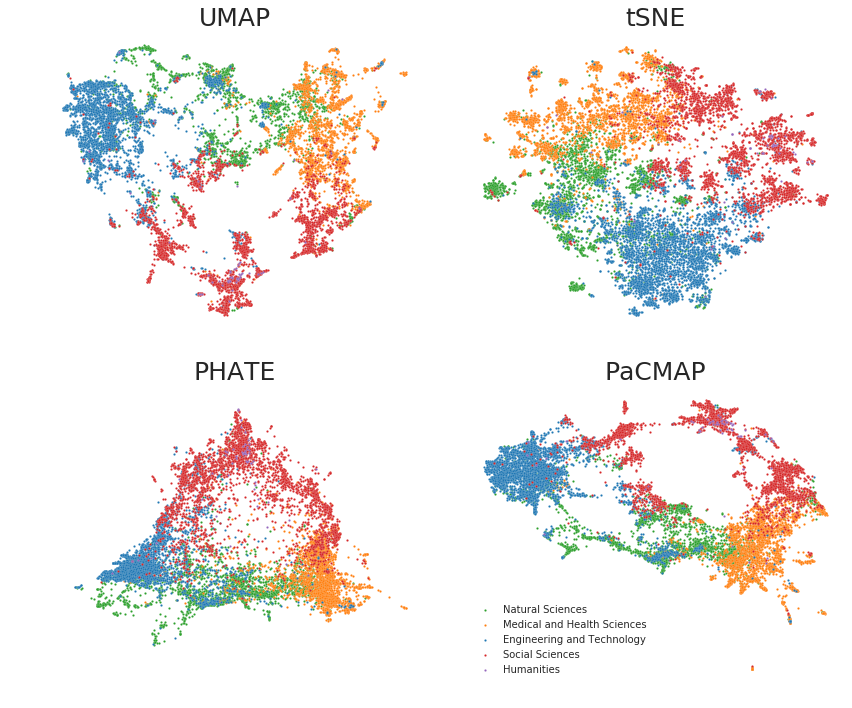

In [1126]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
palette = ['tab:green','tab:orange','tab:blue','tab:red','tab:purple']
xs=[proj_1, proj, proj_2, proj_3]
ts=["UMAP","tSNE","PHATE", "PaCMAP"]
s=0
for row in ax:
    for col in row:
        m=0
        for n in journal_fields.Field.unique():
            col.set_title(ts[s], fontsize=25)
            j1=journal_fields[journal_fields.Field==n].VenueId
            col.scatter([xs[s][tokens_idx[i]][0] for i in j1],[xs[s][tokens_idx[i]][1] for i in  j1], lw=0.1, s=5, edgecolors='white', label=n, c=palette[m])
            m+=1
        s+=1
        col.axis('off')
plt.legend()
fig.tight_layout()
plt.savefig('label.png',  bbox_inches='tight')
plt.show()

**author trajectory matrix**

In [43]:
# get field, author information 
with open('../../../data/Level0.txt','r') as f:
    top=f.read()
top_0=top.split('\n$$')[:-1]
pub=pd.read_csv('../../../data/_author_back.csv')

# get background
fields_2=dict(pd.read_pickle('../../../data//author_fos.pickle')[['AuthorId','Background']].values)
field_dict={'computer science':'Engineering and Technology',
 'sociology': 'Social Sciences',
'political science': 'Social Sciences',
'business': 'Social Sciences',
'geography': 'Social Sciences',
  'psychology':'Social Sciences',
 'geology':  'Natural Sciences',
 'environmental science': 'Natural Sciences',
 'medicine': 'Medical and Health Sciences',
'art': 'Humanities',
 'economics': 'Social Sciences',
  'physics': 'Natural Sciences',
 'philosophy': 'Humanities',
  'mathematics': 'Natural Sciences',
 'biology': 'Natural Sciences',
 'engineering': 'Engineering and Technology',
 'chemistry': 'Natural Sciences',
 'history': 'Humanities',
 'materials science': 'Engineering and Technology'
}

In [13]:
# more processing 
journal_sequence.Year=journal_sequence.Year.astype(float)
journal_sequence=journal_sequence.dropna(subset=['Year'])[journal_sequence.Year>1959].drop_duplicates(subset=['AuthorId','PaperId'])
journal_sequence.Year=journal_sequence.Year.astype(int)
journal_sequence=journal_sequence.astype(str)
journal_sequence_1=journal_sequence[journal_sequence.VenueId.isin(tokens)].reset_index(drop=True)
journal_sequence_1['VenueSequence']=journal_sequence_1.VenueId.apply(lambda i:we_dict[i])
journal_sequence_1['VenueSequence_2d']=journal_sequence_1.VenueId.apply(lambda i:proj_3[tokens_idx[i]])


# aggregate again to get the trajectory matrix 
sequence_1=journal_sequence_1.groupby(['AuthorId']).agg({"OriginalAuthor":'first','Year':'; '.join, 'PaperId':'; '.join, 'VenueId':"; ".join, 'VenueSequence':np.vstack,'VenueSequence_2d':np.vstack,'PaperTitle':'; '.join, 'OriginalVenue':'$;$ '.join}).reset_index()

**Examples of author trajectories**

In [55]:
author_1=journal_sequence_1[journal_sequence_1.AuthorId=='2149865473'].VenueId.to_list()
author_2=journal_sequence_1[journal_sequence_1.AuthorId=='2125888376'].VenueId.to_list()

In [60]:
sequence_new[sequence_new.AuthorId.isin([2125888376,2149865473])][['RadiusOfGyration', 'RadiusOfGyration_2d']]

,RadiusOfGyration,RadiusOfGyration_2d
4445,3.516374,0.906621
5650,2.755841,7.250050


In [56]:
def get_quiver(proj):
    df=pd.DataFrame(columns=['x','y','time'])
    df['x']=proj[:,0]
    df['y']=proj[:,1]
    df['time']=df.index.to_list()
    x1,y1=proj[:,0],proj[:,1]
    x2=x1.copy()
    y2=y1.copy()
    a=len(x1)
    x1,y1=x1[:-1], y1[:-1]
    x2, y2= x2[1:], y2[1:]
    d=pd.DataFrame(x1, columns=['x1'])
    d['y1']=y1
    d['x2']=x2
    d['y2']=y2
    return d

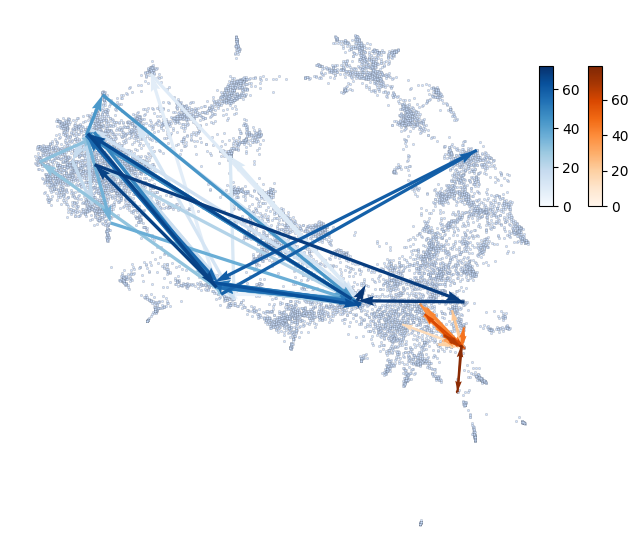

In [59]:
author_2x=np.array([proj_3[tokens_idx[n]] for n in author_2]).reshape(-1,2)
d=get_quiver(author_2x)
fig, ax = plt.subplots(1, figsize=(7,7))
cm = mpt.colormaps.get_cmap('Oranges')
sc=ax.scatter(author_2x[:,0],author_2x[:,1], c=range(len(author_2)), s=2, cmap=cm)
ax.scatter(proj_3[:,0], proj_3[:,1], lw=0.1, s=3, edgecolors='black',c="#CCE0FF", alpha=0.8)
Q=ax.quiver(d['x1'],d['y1'],d['x2']-d['x1'], d['y2']-d['y1'],  angles='xy', scale_units='xy', scale=1, color=np.array(sns.color_palette("Oranges", len(author_2))),  edgecolors='k',width=0.004)

author_1x=np.array([proj_3[tokens_idx[n]] for n in author_1]).reshape(-1,2)
d=get_quiver(author_1x)
sc_1=ax.scatter(author_1x[:,0],author_1x[:,1], c=range(len(author_1)), s=0, cmap=mpl.colormaps.get_cmap('Blues'))
Q_1=ax.quiver(d['x1'],d['y1'],d['x2']-d['x1'], d['y2']-d['y1'],  angles='xy', scale_units='xy', scale=1.005, color=np.array(sns.color_palette("Blues", len(author_1))),  edgecolors='k',width=0.006)
#plt.quiverkey(Q, 0.1, 0.2, 20, label="Sune", labelpos='N', labelcolor="navy", fontproperties={"size":15})
#plt.quiverkey(Q_1, 1.01, 0.6, 30, label="Author1", labelpos='N', labelcolor="Navy",fontproperties={"size":14})
plt.axis('off')
cbaxes = fig.add_axes([0.95, 0.6, 0.02, 0.2])
cbaxes_1 = fig.add_axes([0.88, 0.6, 0.02, 0.2])
plt.colorbar(sc, cax = cbaxes)
plt.colorbar(sc_1, cax = cbaxes_1)
#cbaxes_1.set_ylabel('# of publications', fontsize=12)
plt.show()

**Validation**

In [44]:
journal_fields['Field']=journal_fields.Background.apply(lambda x: field_dict[x])
journal_fields=journal_fields.reset_index(drop=True)

In [15]:
# qualitative 
sample_list=["Proceedings of the National Academy of Sciences of the United States of America", "international conference on weblogs and social media"
        ,   "American Sociological Review", "Journal of Machine Learning Research"]

In [16]:
def find_similar(test): 
    venue_id=journal_sequence_1[journal_sequence_1['OriginalVenue'] == test].VenueId.to_list()[0]
    similar_venues=model.wv.most_similar(venue_id)
    for i,j in similar_venues: 
        print((journal_sequence_1[journal_sequence_1['VenueId'] ==i].OriginalVenue.values[0], j))

In [17]:
find_similar(sample_list[0]) #pnas

('Science', 0.7359088063240051)
('Nature', 0.7242781519889832)
('PLOS Biology', 0.639945924282074)
('Theoretical Ecology', 0.6084572076797485)
('Nature Communications', 0.6067448854446411)
('eLife', 0.6043930053710938)
('Current Biology', 0.6039712429046631)
('Cell', 0.5989400744438171)
('Science Advances', 0.5907796621322632)
('PLOS ONE', 0.5877061486244202)


In [90]:
find_similar(sample_list[1]) #ICWSM

('web science', 0.7527551054954529)
('arXiv: Social and Information Networks', 0.7525091171264648)
('ACM Transactions on The Web', 0.723050057888031)
('the web conference', 0.7077649235725403)
('arXiv: Computers and Society', 0.6805551648139954)
('web search and data mining', 0.6660851240158081)
('social informatics', 0.6647643446922302)
('conference on online social networks', 0.6612645387649536)
('ACM Sigweb Newsletter', 0.6546799540519714)
('acm conference on hypertext', 0.6468027830123901)


In [45]:
find_similar("American Sociological Review")

('Social Forces', 0.8409586548805237)
('Contemporary Sociology', 0.8395533561706543)
('American Journal of Sociology', 0.8018141388893127)
('Social Psychology Quarterly', 0.7854757308959961)
('Social Problems', 0.7608239054679871)
('Sociological Forum', 0.7603782415390015)
('Sociological Theory', 0.7593929171562195)
('Review of Sociology', 0.7221687436103821)
('Qualitative Sociology', 0.7195289134979248)
('Sociological Perspectives', 0.7184267044067383)


In [18]:
find_similar('Scientometrics')

('Journal of Informetrics', 0.9003441333770752)
('arXiv: Digital Libraries', 0.7843062877655029)
('Frontiers in Research Metrics and Analytics', 0.7693609595298767)
('association for information science and technology', 0.7507942914962769)
('Collnet Journal of Scientometrics and Information Management', 0.7480782270431519)
('Research Evaluation', 0.746777355670929)
('Journal of Data and Information Science', 0.7314770221710205)
('Journal of the Association for Information Science and Technology', 0.7089225649833679)
('aslib journal of information management', 0.6983358263969421)
('Revista Espanola De Documentacion Cientifica', 0.6965040564537048)


In [19]:
find_similar('Scientific Reports')

('PLOS ONE', 0.7096204161643982)
('Nature Communications', 0.685639500617981)
('Royal Society Open Science', 0.5800293684005737)
('arXiv: Physics and Society', 0.5709061622619629)
('Physical Biology', 0.5599430799484253)
('Physical Review X', 0.5473889112472534)
('Scientific Data', 0.5444861054420471)
('EPJ Data Science', 0.5393056869506836)
('bioRxiv', 0.5328468680381775)
('European Respiratory Journal', 0.5279113054275513)


In [515]:
# quantitative 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(proj_3)
X_std=scaler.transform(proj_3)
model = KMeans(
    n_clusters=5)
kmean=model.fit_predict(X_std)

In [ ]:
clusters_idx={k:kmean[v] for v, k in enumerate(tokens)}
journal_sequence_1['Clusters']=journal_sequence_1.VenueId.apply(lambda x: clusters_idx[x])
journal_sequence_1

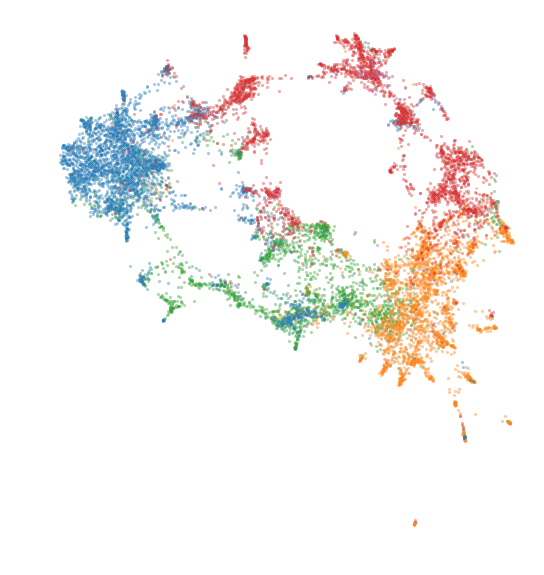

In [92]:
# pacmap with field category
fig, col = plt.subplots(1,1, figsize=(9,10))
palette = ['tab:green','tab:orange','tab:blue','tab:red','tab:purple']
m=0
for n in journal_fields.Field.unique():
    #col.set_title(, fontsize=25)
    j1=journal_fields[journal_fields.Field==n].VenueId
    col.scatter([proj_3[tokens_idx[i]][0] for i in j1],[ proj_3[tokens_idx[i]][1] for i in  j1], lw=0.1, s=10, edgecolors="white", alpha=0.8, label=n, color=palette[])
    m+=1
    plt.axis('off')
#plt.savefig('pacmap.png',  bbox_inches='tight',  dpi=1000)

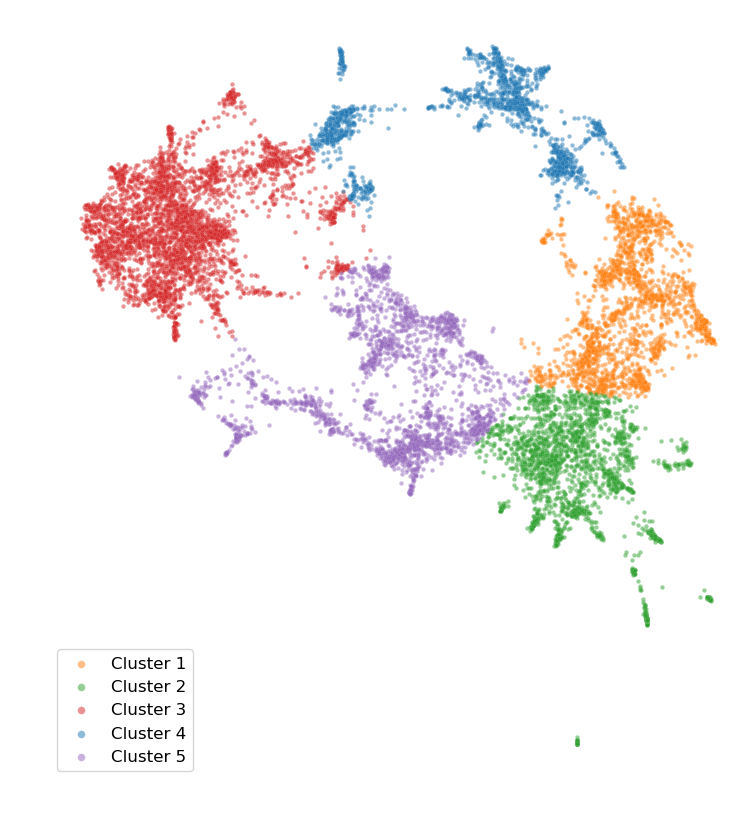

In [528]:
# pacmap with Kmeans clusters 
fig, col = plt.subplots(1,1, figsize=(9,10))
color=[ 'tab:orange','tab:green',  'tab:red','tab:blue','tab:purple']
m=0
for n in range(5):
    #col.set_title(, fontsize=25)
    j1=journal_fields[journal_fields.Cluster==n].VenueId
    col.scatter([proj_3[tokens_idx[i]][0] for i in j1],[ proj_3[tokens_idx[i]][1] for i in  j1], lw=0.1, s=10, edgecolors='white',  label='Cluster '+str(n+1), color=color[m], alpha=0.5)
    m+=1
    lgnd=plt.legend( fontsize=12)
    for i in lgnd.legendHandles:
        i._sizes = [30]
    plt.axis('off')
#plt.savefig('pacmap_1.png',  bbox_inches='tight',  dpi=1000)

In [1102]:
j_name=dict(journal_sequence_1.drop_duplicates(subset=['VenueId'])[['VenueId','OriginalVenue']].values)
f_name=dict(journal_fields[['VenueId','Colors']].values)
c_name={'Natural Sciences':'#2ca02c', 'Medical and Health Sciences': '#ff7f0e',
       'Engineering and Technology':'#1f77b4' , 'Social Sciences': '#d62728', 'Humanities':'#9467bd'}
journal_fields['Colors']=journal_fields.Field.apply(lambda x: c_name[x])

In [1103]:
# save the pacmap for an interactive visualization 
df=pd.DataFrame(proj_3,columns=["aror","asd"])
df['variable']= [j_name[i] for i in tokens]
df['color']= [f_name[i] for i in tokens]
# df.to_csv('dataviz_2.csv', index=False)

In [458]:
from clusim.clustering import Clustering, print_clustering
import clusim.sim as sim

In [519]:
journal_fields['Cluster']=journal_fields.VenueId.apply(lambda x: clusters_idx[x])
cluster_dict={'Natural Sciences':2, 'Medical and Health Sciences':3,
       'Engineering and Technology':1, 'Social Sciences':0, 'Humanities':0}
journal_fields['Cluster_true']=journal_fields['Field'].apply(lambda x: [cluster_dict[x]])
journal_fields['Cluster']=journal_fields['Cluster'].apply(lambda x: [x])

In [509]:
dict_1=dict(journal_fields[['VenueId','Cluster_true']].values)
dict_2=dict(journal_fields[['VenueId','Cluster']].values)
clustering1 = Clustering(elm2clu_dict = dict_1)
clustering2 = Clustering(elm2clu_dict = dict_2)


In [510]:
print("Element-centric Similarity:", sim.element_sim(clustering1, clustering2, alpha = 0.9) )

Element-centric Similarity: 0.5557672333864491


In [511]:
print("Element-centric Similarity for each element:")
elementScores, relabeled_elements = sim.element_sim_elscore(clustering1, clustering2, alpha = 0.9) 
print(elementScores)

Element-centric Similarity for each element:
[0.15817378 0.76789396 0.15817378 ... 0.10956664 0.6013267  0.17012253]


(-15.069783986951776,
 13.873467986951773,
 -18.896015307124998,
 11.332006307124999)

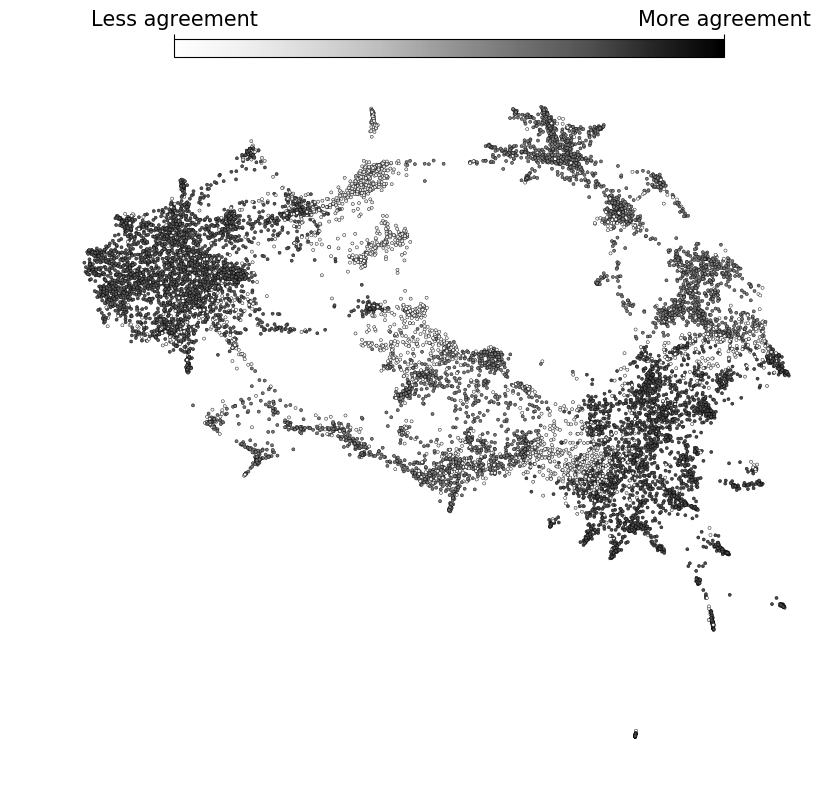

In [514]:
fig, ax = plt.subplots(1,1, figsize=(10,9))
cm = plt.cm.get_cmap('Greys')
sc=plt.scatter([proj_3[tokens_idx[i]][0] for i in journal_fields.VenueId],[proj_3[tokens_idx[i]][1] for i in  journal_fields.VenueId],  s=5, vmin=0, vmax=1, edgecolors='black',  c=elementScores,lw=0.3,  cmap=cm)
cax = fig.add_axes([0.25,0.9, 0.55, 0.02])
cb=plt.colorbar(sc, ax=ax, orientation='horizontal', cax=cax)
cb.ax.xaxis.set_ticks_position('top')
cb.ax.xaxis.set_label_position('top')
cb.set_ticks([0, 1])
cb.set_ticklabels(['Less agreement',"More agreement"], )
for t in cb.ax.get_xticklabels():
     t.set_fontsize(15)
ax.axis('off')
#plt.savefig('pacmap_agreement.png',  bbox_inches='tight')

<hr>

**author trajectory measures**

In [20]:
# some measurements 
sequence_1['PublicationCount']=sequence_1.VenueSequence.apply(lambda x:len(x))
sequence_1['UniqueVenue']=sequence_1.VenueId.apply(lambda x: len(list(set(x.split('; ')))))
sequence_1['YearSpan']=sequence_1.Year.apply(lambda x:eval(x.split('; ')[-1])-eval(x.split('; ')[0])+1)
sequence_1['TotalDistanceNorm']=sequence_1.VenueSequence.apply(lambda x: distance_norm(x))
sequence_1['MeanDistanceNorm']=sequence_1['TotalDistanceNorm']/sequence_1['PublicationCount']
sequence_1['Velocity']=sequence_1['TotalDistanceNorm']/sequence_1['YearSpan']
sequence_1['StdDistanceNorm']=sequence_1.VenueSequence.apply(lambda x: distance_std(x))

sequence_1['AvereageDistanceMidpoint']=sequence_1.VenueSequence.apply(lambda x: Averagetocentroid(x))
sequence_1['RadiusOfGyration']=sequence_1.VenueSequence.apply(lambda x: Gyration(x))
#sequence_1['Midpoint']=sequence_1.VenueSequence.apply(lambda x: middle(x))
#sequence_1['JumpSize']=sequence_1.VenueSequence.apply(lambda x:JumpSize(x))
sequence_1['Trips']=sequence_1.VenueId.apply(lambda x: trips(x))
sequence_1['ShannonEntropy']=sequence_1.Trips.apply(lambda x: estimate_shannon_entropy(x))

# 2d measurements 

#sequence_1['Midpoint_2d']=sequence_1.VenueSequence_2d.apply(lambda x: middle(x))
sequence_1['RadiusOfGyration_2d']=sequence_1.VenueSequence_2d.apply(lambda x: Gyration(x))
#sequence_1['RadiusOfGyration_5d']=sequence_1.VenueSequence_5d.apply(lambda x: Gyration(x))
#sequence_1['RadiusOfGyration_10d']=sequence_1.VenueSequence_10d.apply(lambda x: Gyration(x))
sequence_1['ConvexHullArea']=sequence_1.VenueSequence_2d.apply(lambda x: ConvexArea(x))

In [83]:
# num of authors with more than 20 publications
sequence_2=sequence_1[sequence_1.PublicationCount >20]
sequence_2.shape

(10740, 22)

In [ ]:
# add some author background information 
sequence_2.AuthorId=sequence_2.AuthorId.astype(np.int64)
sequence_new=sequence_2.merge(pub[['AuthorId','Background', 'CitationCount', 'PaperCount']], on=['AuthorId'])

sequences.AuthorId=sequences.AuthorId.astype(np.int64)
sequence_new=sequence_new.merge(sequences[['AuthorId', "AverageCitation", 'Age','MedianCitation','Percentile75Citation']], on=['AuthorId'])
sequence_new.Age=sequence_new.Age.astype(np.int64)
sequence_new['Background_1']=sequence_new.AuthorId.apply(lambda x: fields_2[int(x)])
sequence_new['Field_1']=sequence_new.Background_1.apply(lambda x: field_dict[x])

In [85]:
sequence_new_1=sequence_new[['TotalDistanceNorm', 'MeanDistanceNorm', 'StdDistanceNorm','Velocity','AvereageDistanceMidpoint','ConvexHullArea', 'RadiusOfGyration', 'RadiusOfGyration_2d','ShannonEntropy']]
sequence_new_1.columns=['TotalDistance', 'MeanDistance', 'StdDistance', 'Velocity',
       'AvereageDistanceMidpoint', 'ConvexHullarea', 'RadiusOfGyration',  'RadiusOfGyration_2d', 'ShannonEntropy']

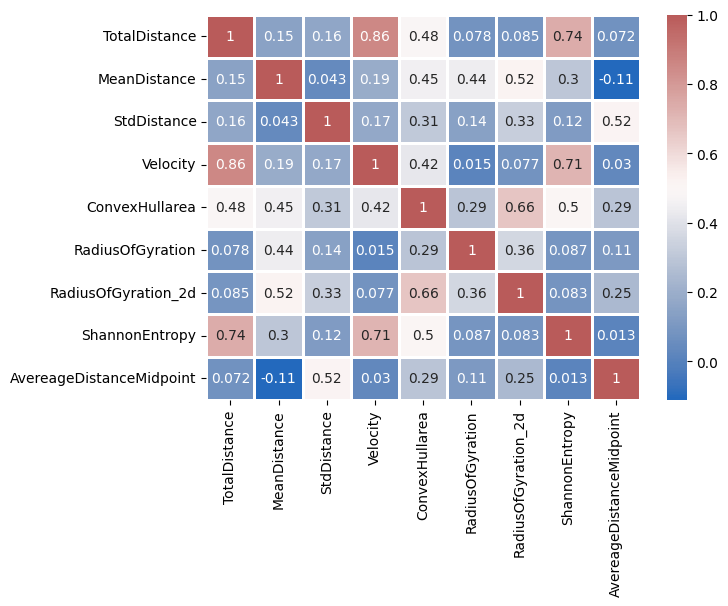

In [86]:
# measure correlation 
ms=['TotalDistance', 'MeanDistance', 'StdDistance', 'Velocity',
        'ConvexHullarea', 'RadiusOfGyration',  'RadiusOfGyration_2d','ShannonEntropy', 'AvereageDistanceMidpoint']
fig, ax=plt.subplots(figsize=(7,5
                             ))    
ax=sns.heatmap(sequence_new_1[ms].corr(), center=0.5,  linewidths=1,cmap="vlag", annot=True )
#sequence_new_1.corr().to_csv('data_cluster.csv', index=False)

In [87]:
np.quantile(sequence_new.AverageCitation.values, q=[0.05, 0.5, 0.99])

array([  3.30769231,  15.12129743, 130.15982982])

In [88]:
new_sample=sequence_new.copy()
#[sequence_new.AverageCitation<131].reset_index(drop=True)

In [285]:
len(sequence_new)

10494

In [286]:
def generate(new_sample, x):
    deciles=np.quantile(new_sample[x].values, q=[i*0.1 for i in range(11)])
    my_dict_1=[]
    for i in range(len(deciles)-1):
        ls=[]
        for j in range(len(new_sample)):
            if deciles[i]<=new_sample[x].values[j]<deciles[i+1]:
                ls.append(j)
        my_dict_1.append(ls)
    return my_dict_1

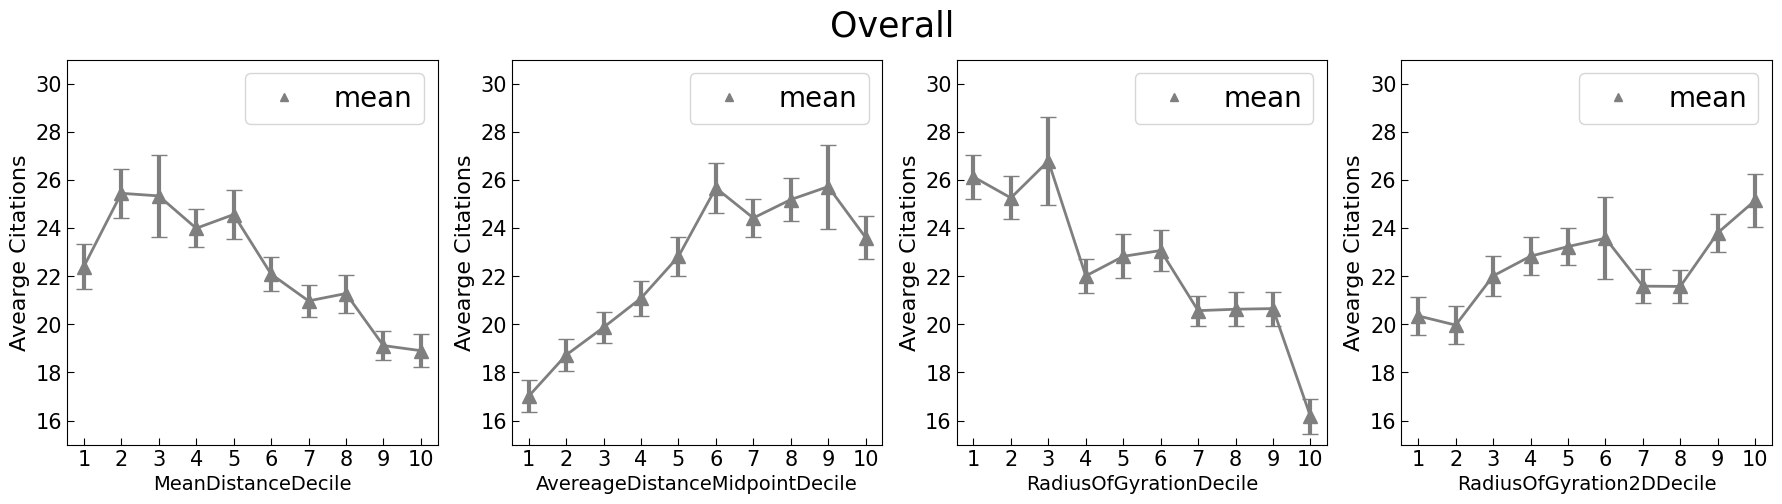

In [287]:
%matplotlib inline
colors = np.array(sns.color_palette("Greys", 15))
fig, axes = plt.subplots(1,4,figsize=(22, 5))
props = dict(widths=0.5,patch_artist=True, medianprops=dict(color="yellow"), showfliers=False)
label=[ 'MeanDistance',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'RadiusOfGyration2D']
ls=[generate(new_sample, i) for i in ['MeanDistanceNorm',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'RadiusOfGyration_2d']]
a=0
fig.suptitle('Overall', fontsize=25) 
for ax1 in axes:
    ey= [new_sample.iloc[ls[a][i]].AverageCitation.mean() for i in range(len(ls[a]))]
    e1 = [new_sample.iloc[ls[a][i]].AverageCitation.std()/np.sqrt(len(new_sample.iloc[ls[a][i]].AverageCitation)) for i in range(10)]
    ex=list(range(1,11))
    ax1.set_ylabel("Avearge Citations",size = 16)
    ax1.set_xlabel(label[a]+'Decile',size = 14)
    ax1.errorbar(ex, ey, e1, marker='^', capsize=6,elinewidth=3,markersize=10, c='tab:gray', markeredgewidth=1, linewidth=2)
    ax1.grid(False)
    ax1.plot([], [], '^', linewidth=1, color='tab:gray', label='mean')
    #mn=new_sample.AverageCitation.mean()
    #ax1.hlines(y=mn, xmin=0, xmax=11,  linestyle='--', color='grey', label='Mean ='+str(int(mn)))
    a+=1
    lgnd=ax1.legend(loc='upper right', fontsize=20, )
    #lgnd.legendHandles[0]._legmarker.set_markersize(10)
    ax1.set_ylim(15,31)
    ax1.set_xticks(np.arange(min(ex), max(ex)+1, 1.0))
    ax1.xaxis.set_tick_params(labelsize=15, direction='in',length=5)
    ax1.yaxis.set_tick_params(labelsize=15, direction='in',length=5)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
#plt.savefig('overall')
plt.show()

In [118]:
mpl.rcParams.update(mpl.rcParamsDefault)
labels = [item.get_text() for item in ax1.get_xticklabels()]

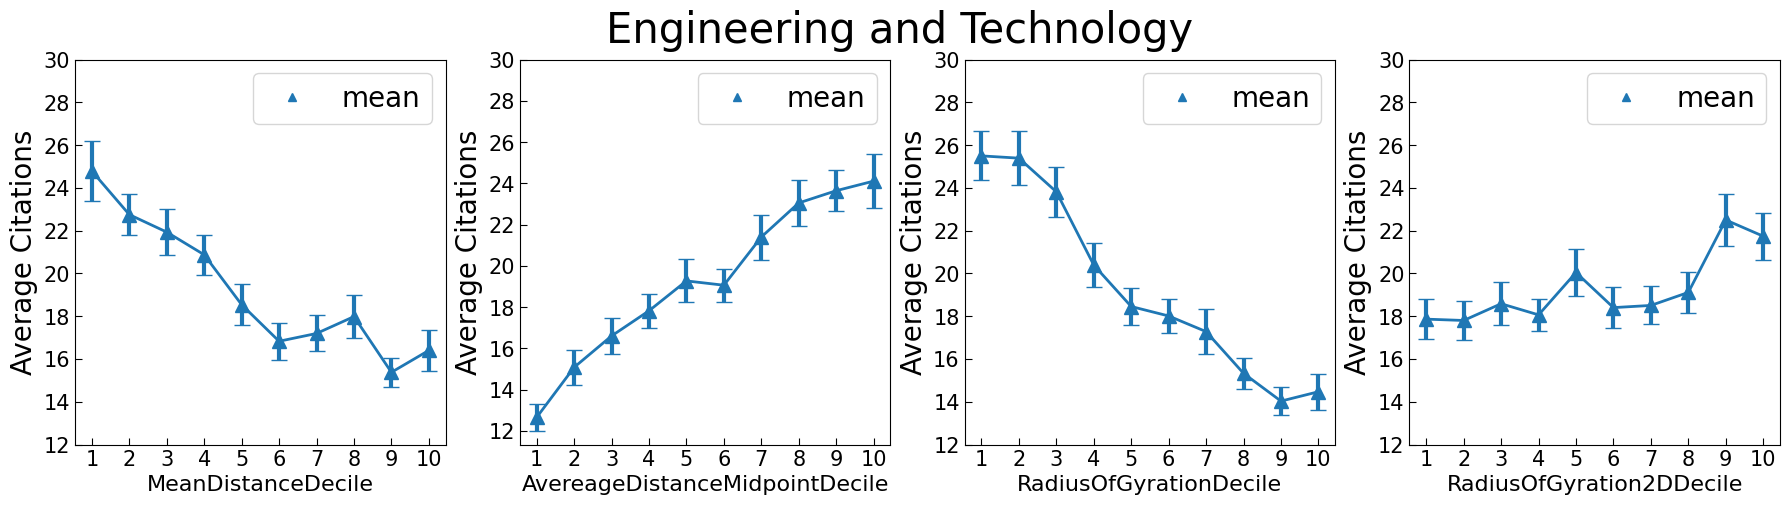

In [124]:
f=2
n= ['Social Sciences',
       'Natural Sciences','Engineering and Technology',  'Medical and Health Sciences','Humanities']
palette = ['tab:red','tab:green','tab:blue','tab:orange','purple']
fig, axes = plt.subplots(1,4,figsize=(22, 5))
fig.suptitle(n[f], fontsize=30) 
new_sample_1=new_sample[new_sample.Field_1==n[f]].reset_index(drop=True)
label=[ 'MeanDistance',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'RadiusOfGyration2D']
ls=[generate(new_sample_1, i) for i in ['MeanDistanceNorm',
       'AvereageDistanceMidpoint', 'RadiusOfGyration', 'RadiusOfGyration_2d']]

a=0
for ax1 in axes:
    ey= [new_sample_1.iloc[ls[a][i]].AverageCitation.mean() for i in range(10)]
    e1 = [new_sample_1.iloc[ls[a][i]].AverageCitation.std()/np.sqrt(len(new_sample_1.iloc[ls[a][i]].AverageCitation)) for i in range(len(ls[a]))]
    ex=list(range(1, 11))
    ax1.set_ylabel("Average Citations",size = 20)
    ax1.errorbar(ex, ey, e1, marker='^', capsize=6,elinewidth=3,markersize=10, c=palette[f],  markeredgewidth=1, linewidth=2)
    ax1.set_xlabel(label[a]+'Decile',size = 16)
    ax1.plot([], [], '^', linewidth=1, color=palette[f],  label='mean')
    a+=1
    lgnd=ax1.legend(loc='upper right', fontsize=20)
    #lgnd.legendHandles[0]._legmarker.set_markersize(10)
    #ax1.set_ylim(15,85)
    ax1.set_xticks(np.arange(min(ex), max(ex)+1, 1.0))
    ax1.set_yticks(np.arange(12, 31, 2.0))
    ax1.xaxis.set_tick_params(labelsize=15, direction='in',length=5)
    ax1.yaxis.set_tick_params(labelsize=15, direction='in',length=5)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
plt.show()

**The radius of gyration as a function of publication number**

In [61]:
def time_gyration(x):
    ls=[]
    for i in range(2, len(x)+1):
        ls.append(Gyration(x[:i]))
    return ls

In [ ]:
sequence_new['t_rg']=sequence_new.VenueSequence.apply(lambda x: time_gyration(x))
sequence_new['t_rg_2d']=sequence_new.VenueSequence_2d.apply(lambda x: time_gyration(x))

In [ ]:
sub=sequence_new[sequence_new.PublicationCount>50].sample(40)
a=sub.t_rg.values
a_1=sub.t_rg_2d.values
c=sub.JumpSize.values

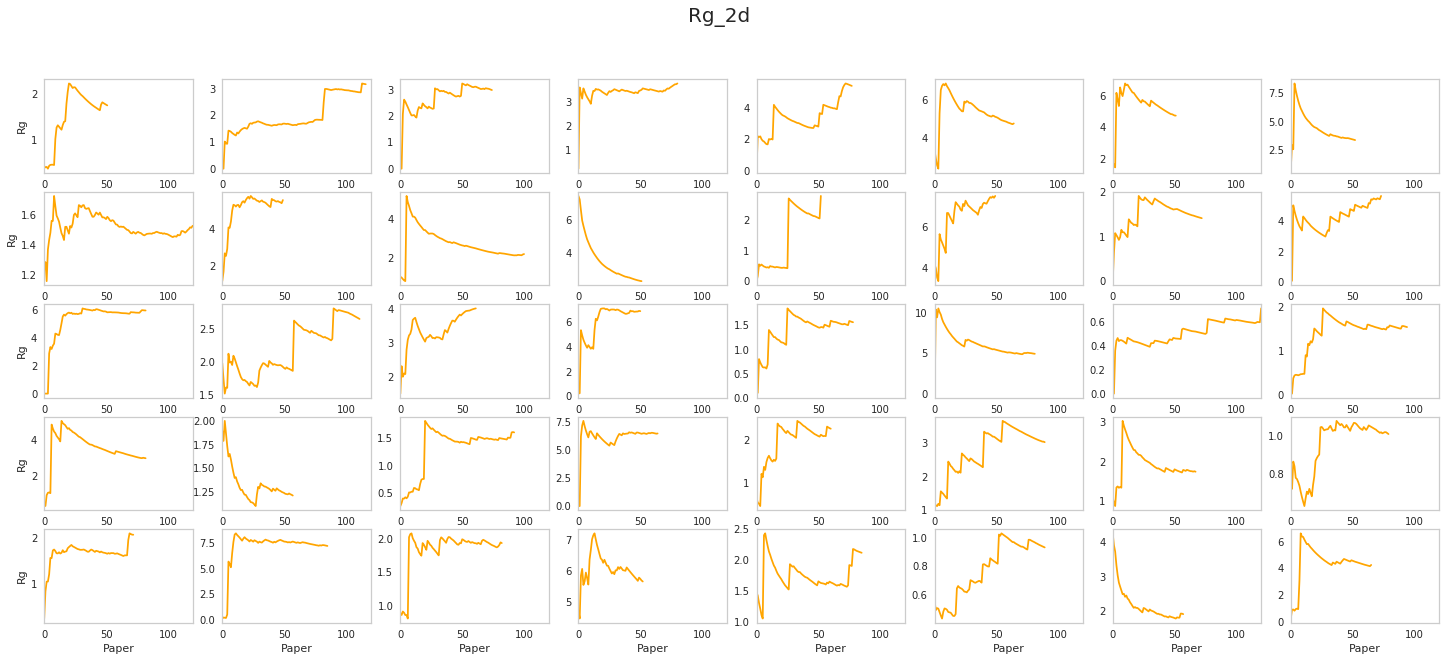

In [761]:
fig=plt.figure(figsize=(25, 10))
fig.suptitle('Rg_2d', fontsize=20) 
b=0
for i in range(5):
    for j in range(8):
        ax=plt.subplot2grid((5,8), (i,j))
        ax.plot(a_1[b], color='orange')
        ax.set_xlim(0, 120)
        #ax.set_ylim(0, 5)
        ax.grid(False)
        ax.set_xlabel('Paper')
        if b %8==0:
            ax.set_ylabel('Rg')
        b+=1
plt.show()

<hr>

**regression**

In [90]:
# map background to OECD fields
field_dict={'computer science':'Engineering and Technology',
 'sociology': 'Social Sciences',
'political science': 'Social Sciences',
'business': 'Social Sciences',
'geography': 'Social Sciences',
  'psychology':'Social Sciences',
 'geology':  'Natural Sciences',
 'environmental science': 'Natural Sciences',
 'medicine': 'Medical and Health Sciences',
'art': 'Humanities',
 'economics': 'Social Sciences',
  'physics': 'Natural Sciences',
 'philosophy': 'Humanities',
  'mathematics': 'Natural Sciences',
 'biology': 'Natural Sciences',
 'engineering': 'Engineering and Technology',
 'chemistry': 'Natural Sciences',
 'history': 'Humanities',
 'materials science': 'Engineering and Technology'
}
sequence_new=sequence_new[sequence_new.Background.isin(top_0)].reset_index(drop=True)
sequence_new['Field']=sequence_new.Background.apply(lambda x: field_dict[x])


In [91]:
# get the last known affiliation from mag
affiliation=pd.read_pickle('../data/affilication_detail0.pickle')
df= affiliation.drop_duplicates(subset=['AffiliationId'])[['Latitude', 'Longitude']].reset_index(drop=True)
ids=affiliation.drop_duplicates(subset=['AffiliationId']).AffiliationId.reset_index(drop=True).values
coordinates = [(df.Latitude[i].round(2), df.Longitude[i].round(2)) for i in range(len(df))]

# from coordinate to country 
my_dict={}
for i in range(len(coordinates)):
    try:
        my_dict[ids[i]]=reverse_geocode.search([coordinates[i]])[0]
    except:
        pass

# from country to continent
for i in range(len(affiliation)):
    try:
        inf=my_dict[affiliation.AffiliationId[i]]
        affiliation.loc[i, 'Region']= inf['country']
        affiliation.loc[i, 'Continent']= pc.country_alpha2_to_continent_code(inf['country_code'])
    except:
        pass



In [92]:
# get continent for authors
sequence_new=sequence_new.merge(affiliation[['AuthorId','Continent']], on=['AuthorId'])

In [102]:
# standardize the rg
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(sequence_new.RadiusOfGyration.values.reshape(-1, 1))
X_std_1=scaler.transform(sequence_new.RadiusOfGyration.values.reshape(-1, 1))
sequence_new['RadiusOfGyration_std']=[i[0] for i in X_std_1]

# 2d
scaler = StandardScaler()
scaler.fit(sequence_new.RadiusOfGyration_2d.values.reshape(-1, 1))
X_std=scaler.transform(sequence_new.RadiusOfGyration_2d.values.reshape(-1, 1))
sequence_new['RadiusOfGyration_std_1']=[i[0] for i in X_std]

In [32]:
sequence_new['RadiusOfGyration_std_2']=sequence_new['RadiusOfGyration_std'] -sequence_new['RadiusOfGyration_std_1']
scaler = StandardScaler()
sequence_new['RadiusOfGyration_std_2']=scaler.fit_transform(sequence_new.RadiusOfGyration_std_2.values.reshape(-1, 1))

In [103]:
# guess gender
import gender_guesser.detector as gender
df=sequence_new.copy()
d = gender.Detector()
def get_first_name(x): 
    return x.split(' ')[0]
df['Name_gender']=df.OriginalAuthor.apply(lambda x:d.get_gender(get_first_name(x)).split('_')[-1] if(pd.notnull(x)) else x)
#df=df[df.Name_gender!='unknown'].reset_index(drop=True)
df['Name_gender']=df.Name_gender.apply(lambda x: x.replace('andy','unknown'))
len(df[df.Name_gender=='unknown'])/len(df)
df=df.dropna(subset=['AverageCitation','PublicationCount','RadiusOfGyration_std','RadiusOfGyration_std_1','Age', 'Continent', 'Field_1']).reset_index(drop=True)

In [104]:
len(df)

10480

In [120]:
np.quantile(df.CitationCount.values, q=[0.02, 0.5, 0.98])
#df_1=df_1[df_1.PublicationCount >= 10].reset_index(drop=True)

array([   82.  ,  1057.5 , 22169.12])

In [179]:
df_1=df.copy()

In [180]:
# regression
from statsmodels.formula.api import ols

fit = ols('Percentile75Citation ~ RadiusOfGyration_std+C(Field_1)+Age+C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1') 
fit_1 = ols('AverageCitation~ RadiusOfGyration_std+C(Field_1)+Age +C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1') 
fit_2 = ols('MedianCitation~ RadiusOfGyration_std+C(Field_1)+Age +C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1')
fit_3 = ols('RadiusOfGyration_std~ RadiusOfGyration_std_1', data=df_1).fit(cov_type='HC1')

In [55]:
df['Residual']=  df.RadiusOfGyration_std-df.RadiusOfGyration_std_1*fit_3.params[1]+fit_3.params[0]

In [181]:
from statsmodels.iolib.summary2 import summary_col
print(summary_col([ fit_1, fit_2, fit],stars=True,float_format='%0.2f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}).as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{llll}
\hline
                                           & AverageCitation & MedianCitation & Percentile75Citation  \\
\hline
Intercept                                  & -4.81**         & 0.26           & -1.14                 \\
                                           & (1.93)          & (0.61)         & (1.71)                \\
C(Field\_1)[T.Humanities]                  & -12.68**        & -4.72***       & -12.51***             \\
                                           & (5.15)          & (1.47)         & (4.72)                \\
C(Field\_1)[T.Medical and Health Sciences] & -0.04           & -0.14          & 0.93                  \\
                                           & (0.67)          & (0.18)         & (0.59)                \\
C(Field\_1)[T.Natural Sciences]            & 12.99***        & 3.92***        & 11.09***              \\
                                           & (2.59)          & (0.32)      

**heterogeneity analysis**

In [182]:
# slice the dataset based on age

def generate(new_sample, x):
    deciles=np.quantile(new_sample[x].values, q=[i*0.3333 for i in range(4)])
    my_dict_1=[]
    for i in range(len(deciles)-1):
        ls=[]
        for j in range(len(new_sample)):
            if deciles[i]<=new_sample[x].values[j]<deciles[i+1]:
                ls.append(j)
        my_dict_1.append(ls)
    return my_dict_1
#df_1=df_1.dropna(subset=['RadiusOfGyration_std', 'Age', 'MeanDistanceNorm','AvereageDistanceMidpoint']).reset_index(drop=True)
ls=generate(df, 'Age')
a=0
df['Decile']=0
for i in ls:
    for n in i:
        df.loc[n,'Decile']=a
    a+=1
    

In [207]:
df_1=df[df.Decile==2].reset_index(drop=True)

In [208]:
# regression

fit = ols('Percentile75Citation ~ RadiusOfGyration_std+C(Field_1)+C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1') 
fit_1 = ols('AverageCitation~ RadiusOfGyration_std+C(Field_1)+C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1') 
fit_2 = ols('MedianCitation~RadiusOfGyration_std+C(Field_1) +C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1')

In [209]:
summary_col([ fit_1, fit_2, fit],stars=True,float_format='%0.2f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))})

,AverageCitation,MedianCitation,Percentile75Citation
Intercept,16.87***,6.47***,17.98***
,(3.93),(1.05),(3.26)
C(Field_1)[T.Humanities],-18.89***,-6.41***,-18.25***
,(3.44),(0.54),(2.38)
C(Field_1)[T.Medical and Health Sciences],1.15,0.81**,3.25***
,(1.18),(0.34),(0.98)
C(Field_1)[T.Natural Sciences],18.42***,5.40***,13.91***
,(5.29),(0.55),(1.59)
C(Field_1)[T.Social Sciences],15.23***,6.49***,18.57***
,(1.64),(0.49),(1.45)


In [223]:
# slice based on field 
f=4
n= ['Social Sciences',
       'Natural Sciences','Engineering and Technology',  'Medical and Health Sciences','Humanities']
df_2=df[df.Field_1==n[f]].reset_index(drop=True)

In [224]:
# regression
fit = ols('Percentile75Citation ~ RadiusOfGyration_std+Age+C(Continent)+ C(Name_gender)', data=df_2).fit(cov_type='HC1') 
fit_1 = ols('AverageCitation~ RadiusOfGyration_std+Age+C(Continent)+ C(Name_gender)', data=df_2).fit(cov_type='HC1') 
fit_2 = ols('MedianCitation~RadiusOfGyration_std+Age+C(Continent)+ C(Name_gender)', data=df_2).fit(cov_type='HC1')

In [225]:
summary_col([ fit_1, fit_2, fit],stars=True,float_format='%0.2f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))})

,AverageCitation,MedianCitation,Percentile75Citation
Intercept,29.52*,6.07,26.25
,(17.94),(5.23),(18.88)
C(Continent)[T.NA],-0.92,-2.34,-6.40
,(7.83),(4.12),(9.50)
C(Name_gender)[T.male],-1.87,1.14,0.02
,(10.11),(4.07),(10.43)
C(Name_gender)[T.unknown],-10.52,1.72,-3.85
,(12.07),(4.08),(13.05)
RadiusOfGyration_std,-7.14,-0.87,-5.01
,(8.60),(1.95),(8.17)


In [272]:
# slice based on continent 
f=5
n= ['EU', 'OC', 'SA', 'NA', 'AS', 'AF']
df_2=df[df.Continent==n[f]].reset_index(drop=True)

In [273]:
# regression
fit = ols('Percentile75Citation ~ RadiusOfGyration_std+Age+C(Field_1)+ C(Name_gender)', data=df_2).fit(cov_type='HC1') 
fit_1 = ols('AverageCitation~ RadiusOfGyration_std+Age+C(Field_1)+ C(Name_gender)', data=df_2).fit(cov_type='HC1') 
fit_2 = ols('MedianCitation~RadiusOfGyration_std+Age+C(Field_1)+ C(Name_gender)', data=df_2).fit(cov_type='HC1')

In [274]:
summary_col([ fit_1, fit_2, fit],stars=True,float_format='%0.2f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))})

,AverageCitation,MedianCitation,Percentile75Citation
Intercept,6.79,2.56,8.43*
,(5.50),(2.23),(4.99)
C(Field_1)[T.Medical and Health Sciences],16.17***,3.35*,13.37**
,(5.66),(1.84),(5.89)
C(Field_1)[T.Natural Sciences],23.74***,10.44***,26.48***
,(7.39),(2.75),(6.51)
C(Field_1)[T.Social Sciences],8.32***,3.16**,6.51**
,(3.01),(1.44),(3.18)
C(Name_gender)[T.male],-4.88,-1.82,-5.89
,(4.97),(2.22),(5.01)


In [282]:
# slice based on gender
f=2
n= ['male', 'unknown', 'female']
df_2=df[df.Name_gender==n[f]].reset_index(drop=True)

In [283]:
# regression
fit = ols('Percentile75Citation ~ RadiusOfGyration_std+Age+C(Field_1)+C(Continent)', data=df_2).fit(cov_type='HC1') 
fit_1 = ols('AverageCitation~ RadiusOfGyration_std+Age+C(Field_1)+C(Continent)', data=df_2).fit(cov_type='HC1') 
fit_2 = ols('MedianCitation~RadiusOfGyration_std+Age+C(Field_1)+C(Continent)', data=df_2).fit(cov_type='HC1')


In [284]:
summary_col([ fit_1, fit_2, fit],stars=True,float_format='%0.2f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))})

,AverageCitation,MedianCitation,Percentile75Citation
Intercept,-1.69,0.46,1.84
,(6.72),(2.68),(6.65)
C(Field_1)[T.Humanities],1.08,-1.75***,-0.01
,(4.72),(0.60),(4.14)
C(Field_1)[T.Medical and Health Sciences],-0.17,-0.35,-0.29
,(2.29),(0.57),(1.56)
C(Field_1)[T.Natural Sciences],27.94,3.69***,11.26***
,(20.63),(0.96),(3.41)
C(Field_1)[T.Social Sciences],7.59***,3.75***,10.14***
,(2.05),(0.59),(1.62)


In [239]:
# slice based on citation quartile 
def generate(new_sample, x):
    deciles=np.quantile(new_sample[x].values, q=[i*0.25 for i in range(5)])
    my_dict_1=[]
    for i in range(len(deciles)-1):
        ls=[]
        for j in range(len(new_sample)):
            if deciles[i]<=new_sample[x].values[j]<deciles[i+1]:
                ls.append(j)
        my_dict_1.append(ls)
    return my_dict_1
#df_1=df_1.dropna(subset=['RadiusOfGyration_std', 'Age', 'MeanDistanceNorm','AvereageDistanceMidpoint']).reset_index(drop=True)
ls=generate(df, 'AverageCitation')
a=0
df['Quartile']=0
for i in ls:
    for n in i:
        df.loc[n,'Quartile']=a
    a+=1
    

In [245]:
df_1=df[df.Quartile==1].reset_index(drop=True)
fit = ols('Percentile75Citation ~ RadiusOfGyration_std+C(Field_1)+Age+C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1') 
fit_1 = ols('AverageCitation~ RadiusOfGyration_std+C(Field_1)+Age +C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1') 
fit_2 = ols('MedianCitation~ RadiusOfGyration_std+C(Field_1)+Age +C(Continent)+ C(Name_gender)', data=df_1).fit(cov_type='HC1')

In [246]:
summary_col([ fit_1, fit_2, fit],stars=True,float_format='%0.2f', info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))})

,AverageCitation,MedianCitation,Percentile75Citation
Intercept,10.21***,5.55***,13.58***
,(0.49),(0.47),(0.73)
C(Field_1)[T.Humanities],-0.77,-1.02,-1.54
,(1.16),(2.12),(2.99)
C(Field_1)[T.Medical and Health Sciences],-0.03,-0.54***,0.20
,(0.11),(0.11),(0.21)
C(Field_1)[T.Natural Sciences],0.06,0.72***,1.25***
,(0.17),(0.18),(0.31)
C(Field_1)[T.Social Sciences],0.21*,0.68***,1.52***
,(0.12),(0.13),(0.25)


**Correlation between Rg and Rg_2d**

In [124]:
from scipy.stats import gaussian_kde
x=df.RadiusOfGyration_2d
y=df.RadiusOfGyration
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

In [162]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.AverageCitation.values.reshape(-1, 1))
X_std=scaler.transform(df.AverageCitation.values.reshape(-1, 1))
citations=[i[0] for i in X_std]

In [126]:
df[['RadiusOfGyration_2d','RadiusOfGyration']].corr()

,RadiusOfGyration_2d,RadiusOfGyration
RadiusOfGyration_2d,1.000000,0.360602
RadiusOfGyration,0.360602,1.000000


In [127]:
scipy.stats.pearsonr(df.RadiusOfGyration_std_1, df.RadiusOfGyration_std)  

PearsonRResult(statistic=0.3606023914775087, pvalue=2.43614e-319)

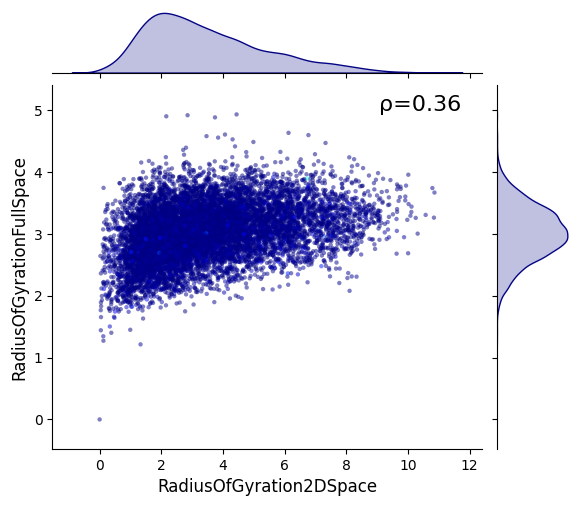

In [169]:
g = sns.JointGrid(data=df, x="RadiusOfGyration_2d", y="RadiusOfGyration",)
g.plot_joint(sns.scatterplot,   s=10,  cmap='jet', c= citations,  alpha=0.5, linewidth=0, sizes=(10, 5))
g.plot_marginals(sns.kdeplot, color='#040484', fill=True)
g.set_axis_labels('RadiusOfGyration2DSpace', 'RadiusOfGyrationFullSpace', fontsize=12)
plt.text(-1.5, 5, 'ρ=0.36', fontsize=16 )
g.fig.set_figwidth(6)
g.fig.set_figheight(5)